In [1]:
# the usual boilerplate stuff
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
dum = plt.rcParams['text.usetex'] = False  # can use latex in figures
np.set_printoptions(precision=3)

# PART TWO: we build in a covariance function, reflecting our prior beliefs

So far, we know that a *family* of functions will have a *covariance curve*. This curve might not say everything about that family. But it says everything about *a* family. This latter family is called a _Gaussian Process_.

Let's make samples from a Gaussian Process with a Covariance Function that we just _make up_ a shape for then!

In [2]:
N=101
X = np.linspace(-5,5,N)

In [3]:
# the KERNEL is just a function of two points in x-space. 
# These really ought to each be vectors, but for simplicity we're playing around
# with a 1-dimensional x-space here so they're just scalars :(   [easily fixed]
def kernel(x1,x2,params):
    # x1, x2 should be scalars
    
    d = np.abs(x1-x2)
    
    prior_pairwise_covar = params['theta_peak'] * np.exp(-(d/params['theta_width'])**params['exponent'])
    if x1==x2:
        prior_pairwise_covar += params['theta_noise'] 
    return prior_pairwise_covar

#-------------------------------------------------------------------

params = {'theta_width': 1.5, 'theta_peak': 1.0, 'theta_noise': 0.01, 'exponent': 2.0}
# YOU CAN PLAY WITH ANY OF THOSE NUMBERS: PLEASE DO.
# THEY ARE ASSUMPTIONS! Could be wrong for a given data set.
#
# theta_width controls how kernel fades with x distance
# theta_peak controls the overall vertical (meaning y) "scale" of the variations
# theta_noise is std dev of the measurement noise
# Finally there's the exponent (try 1.0, try 2.0, or something in between)


# sanity check example
kernel(1.,1.01,params)

0.9999555565431952

So far that's just a "kernel". We can plot it out for various distances, and interpret it as the _covariance_, so we'll get _cov as a  function of distance_, just like we did empirically in the first section.

Notice we have parameters describing the shape. Play with those, e.g. try to make something similar to the empirical curve you saw earlier!

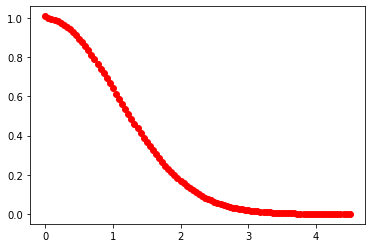

In [4]:
dumd = np.linspace(0,3*params['theta_width'],100)
dumc = []
for d in dumd:
    dumc.append(kernel(0,d,params))
plt.plot(dumd,dumc,'or')

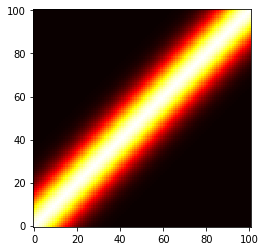

In [5]:
# this isn't very "numpy" style, but oh well!
def makeCovMatrix(X,params):
    N = len(X)
    cv = np.zeros((N,N),dtype=float)
    for i,x1 in enumerate(X):
        for j,x2 in enumerate(X):
            cv[i,j] = kernel(x1,x2,params)
    return cv

# sanity: let's see it
cov_matrix = makeCovMatrix(X,params)
plt.imshow(cov_matrix, interpolation='nearest', origin='lower', cmap='hot')

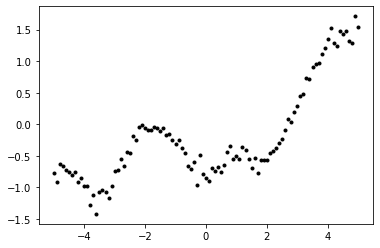

In [6]:
y = rng.multivariate_normal(0.0*np.ones(len(X)),cov_matrix)  # "usually" a mean of zeros
plt.plot(X,y,'.k')

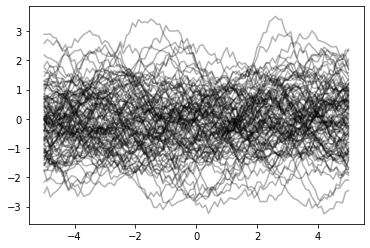

In [7]:
# make a whole bunch
cov_matrix = makeCovMatrix(X,params)

y = rng.multivariate_normal(np.zeros(len(X)),cov_matrix,100)
for i in range(100):
    plt.plot(X,y[i],'-k',alpha=.3)

In fact, let's find the mean and standard dev of y, at every x point.

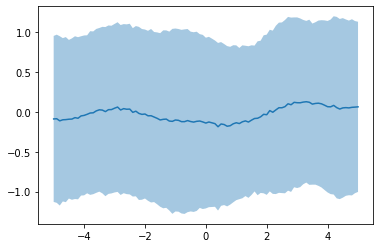

In [8]:
ymean = np.mean(y,axis=0)
ystd = np.std(y,axis=0)

plt.fill_between(X,ymean+ystd,ymean-ystd,alpha=.4)
plt.plot(X,ymean)

But... why sample at all? That ought to be the same as what the multivariate Gaussian says, which is that the mean is zero, and the std dev is, well, the square root of the covariance matrix, along its diagonal, it seems to me.

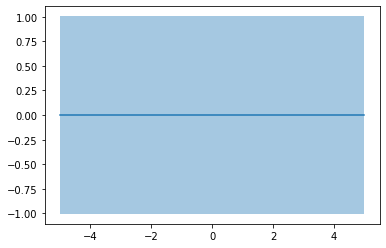

In [9]:
ymean = np.zeros(N)
ystd = np.sqrt(np.diag(cov_matrix))

plt.fill_between(X,ymean+ystd,ymean-ystd,alpha=.4)
plt.plot(X,ymean)

### important note!
Even though we keep sampling here, the real deal doesn't involve any sampling at all, and these curves are just for illustrating the underlying maths.

# finally the cool part: _observe_ y vals at some x's

If we "slice through" this high-dimensional Gaussian, by *actually observing* some of the y-values of specific x-values, we'd be left with a still-quite-high dimensional Gaussian.
This is called "conditioning".

As we know the result of conditioning is easily obtained, analytically (there's no need to sample), and both the mean and the new covariance matrix follow (nb. my nomenclature below matches wikipedia https://www.wikiwand.com/en/Multivariate_normal_distribution#/Conditional_distributions rather than Murphy, but math is math)

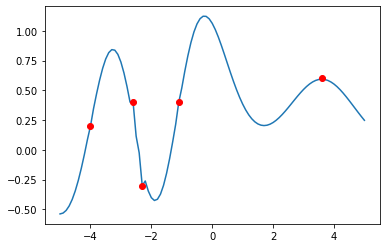

In [11]:
iObs = [24,10,86,27,39]; yObs = [.4,.2,.6,-.3,.4]
iNot = [i for i in range(N) if i not in iObs]  # ie. all the others.

C11 = cov_matrix[iNot].T[iNot] 
C22 = cov_matrix[iObs].T[iObs]
C12 = cov_matrix[iObs].T[iNot] 
C21 = cov_matrix[iNot].T[iObs] 
#print(C11.shape, C12.shape, C21.shape, C22.shape)

invC22 = np.linalg.inv(C22)

tmp = np.dot(C12,invC22)

mu = np.zeros(N)
muNot = np.dot(tmp, np.atleast_2d(yObs).T)[:,0]

mu[iObs] = yObs
mu[iNot] = muNot

# might as well plot just the mean prediction, as a test...
plt.plot(X,mu)
plt.plot(X[iObs], yObs, 'or') # the data points we've observed

And the (posterior) covariance matrix is now...

$
\overline{\boldsymbol\Sigma}
=
\boldsymbol\Sigma_{11} - \boldsymbol\Sigma_{12} \boldsymbol\Sigma_{22}^{-1} \boldsymbol\Sigma_{21}.
$

In [12]:
Cbar = C11 - np.dot(tmp, C21)
new_cov_matrix = np.zeros((N,N))


# this is a tedious way, elt by elt, but oh anyway...
for ii, i in enumerate(iObs):
    for jj, j in enumerate(iObs):
        new_cov_matrix[i,j] = params['theta_noise']
for ii, i in enumerate(iNot):
    for jj, j in enumerate(iNot):
        new_cov_matrix[i,j] = Cbar[ii,jj]

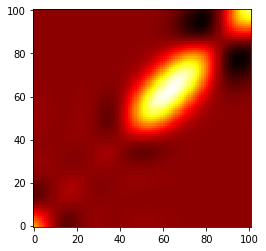

In [13]:
#plt.imshow(C11 - np.dot(tmp, C21), interpolation='nearest',origin='lower')
plt.imshow(new_cov_matrix, interpolation='nearest',origin='lower', cmap='hot')

### show the prediction distribution now
So now we can show the mean, plus "error bars" (as before, the diagonal elts of cov).

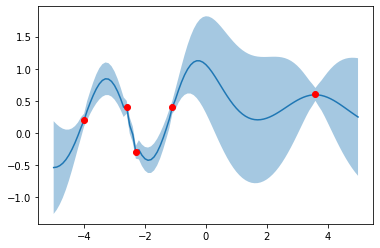

In [14]:
ymean = mu
ystd = np.sqrt(np.diag(new_cov_matrix))
plt.fill_between(X,ymean+ystd,ymean-ystd,alpha=.4)
plt.plot(X,ymean)

plt.plot(X[iObs], yObs, 'or') # the data points we've observed

It's not of any additional benefit really, but for the hell of it, let's draw some samples from the new multivariate Gaussian with this mean and this Cov-matrix. ie, make some curves...


_UNSURE / TODO: It's possible I haven't got the C12 and C21 right yet. They don't seem to be contributing, and maybe it's only not causing a problem because there are only a few known points._

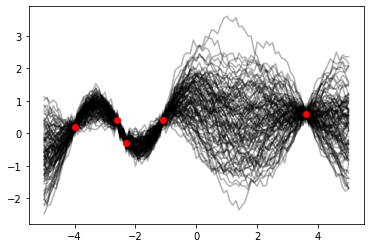

In [15]:
yvariation = rng.multivariate_normal(ymean,new_cov_matrix,100)
y = yvariation
for i in range(100):
    plt.plot(X,y[i],'-k',alpha=.3)
plt.plot(X[iObs], yObs, 'or') # the data points we've observed

NOTE: this isn't the way you'd do prediction in practice. For a start, there's no need to worry about all those x points that don't have observations, unless you want a specific prediction there. And of course no need to sample (which wouldn't be illustrative if the input dimensionality was higher than 2 anyway!).

So......


# Gaussian Process prediction in practice

In [16]:
# Short summary: if the data is....
X_data = [-4.,-3,-2.5,1.,3.]
y_data = [.4,.2,.6,-.3,.4]

# and parameters are
params = {'theta_width': 1.5, 'theta_peak': 1.0, 'theta_noise': 0.01, 'exponent': 1.0}

# we make up a covariance matrix
cov_matrix = makeCovMatrix(X_data,params)
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [32]:
def prediction(x_query, X, y, params):
    n = len(X)
    Kvec = np.zeros(n)
    for k in range(n):
        Kvec[k] = kernel(X[k], x_query, params)

    tmp = np.dot(Kvec,inv_cov_matrix) # used in both mean and var.
    tmp = np.atleast_2d(tmp)
    mu = np.dot(tmp,np.atleast_2d(y).T)[0,0]  # should be a 1x1 "matrix"!
    var = params['theta_peak'] - np.dot(tmp,Kvec)[0]
    var = max(var,0.0)
    return(mu, var)

xs = np.linspace(-5.0,5.0,101)
y_means = np.zeros(len(xs))
y_stds  = np.zeros(len(xs))
for i,x_query in enumerate(xs):
    mu, var = prediction(x_query, X_data, y_data, params)
    std = np.sqrt(var) + params['theta_noise']
    #print('x={0:.2f}  prediction={1:.2f} \t (std dev of {2:.2})'.format(x_query,mu,std))
    
    y_means[i], y_stds[i] = mu, std

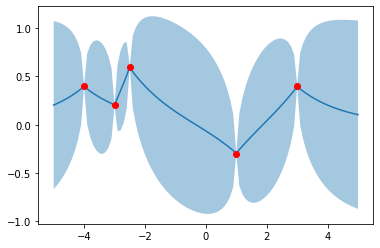

In [33]:
plt.fill_between(xs,y_means+y_stds,y_means-y_stds,alpha=.4)
plt.plot(xs,y_means)

plt.plot(X_data, y_data, 'or') # the data points we've observed

Seems to work! 

Obviously we don't want to be stuck in only 1-d domains. Happily, since x only enters via the kernel, it's trivial to move up to vectors.
Nb. in doing so, it makes sense to have one theta_width for each dimension of the input space.

The other thing we haven't covered yet is _learning_ of the theta parameters. You can do this by gradient descent based on the data you've seen.